In [41]:
import os
from pathlib import Path
import uproot
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


# The following command display the current working directory (where jupyter has been launched)
# and select the output folder
cwd = os.getcwd()
folder = Path(cwd) / 'output'
if (not folder.is_dir()):
    print(f'ERROR: {folder} is not a folder.')
print(f'The Current Working Directory (CWD) is {cwd}')
print(f'The output folder is {folder}')

The Current Working Directory (CWD) is /Users/jemmabagg/Documents/Masters/picoPET-sim
The output folder is /Users/jemmabagg/Documents/Masters/picoPET-sim/output


In [42]:
filename = os.path.join(folder, "output_vereos.root")
f = uproot.open(filename)

# print the list of trees
for t in f:
    print(f'Tree {t}')

# get the first tree and print the branches
hits = f['Singles1']

df = f['Singles1'].arrays(["PostPosition_X", "PostPosition_Y", "PostPosition_Z", "TotalEnergyDeposit",  "GlobalTime", "LocalTime"], library="pd")

print(f'Number of hits : {hits.num_entries}')
for b in hits:
    print(f'Branch {b.name}')

df.head()

Tree Hits;1
Tree Singles1;1
Tree Singles2;1
Tree Singles3;1
Tree Singles4;1
Tree Singles5;1
Number of hits : 1925282.0
Branch PostPosition_X
Branch PostPosition_Y
Branch PostPosition_Z
Branch TotalEnergyDeposit
Branch PreStepUniqueVolumeID
Branch GlobalTime
Branch LocalTime


,PostPosition_X,PostPosition_Y,PostPosition_Z,TotalEnergyDeposit,GlobalTime,LocalTime
0,11.785662,174.614141,14.0,0.510999,16238.828963,0.239280
1,-7.727737,175.388945,2.0,0.510999,17809.180725,0.292413
2,100.145946,144.193584,2.0,0.443233,32635.121161,0.398270
3,93.851486,148.367445,-2.0,0.067766,32635.082931,0.354271
4,-174.874372,6.924890,2.0,0.510999,32635.388073,0.659413


In [43]:
def find_coincidences(df: pd.DataFrame, time_window: float) -> pd.DataFrame:
    """
    Find photon coincidences within a given time window.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing photon measurements with the columns:
                           ["PostPosition_X", "PostPosition_Y", "PostPosition_Z",
                            "TotalEnergyDeposit", "GlobalTime", "LocalTime"].
        time_window (float): Maximum allowed time difference between photon pairs.
        
    Returns:
        pd.DataFrame: DataFrame where each row represents a coincidence pair.
                      The columns are the original attributes suffixed with _1 and _2.
    """
    # Sort the dataframe by GlobalTime for an efficient sliding-window search.
    df_sorted = df.sort_values("GlobalTime").reset_index(drop=True)
    times = df_sorted["GlobalTime"].values
    n = len(df_sorted)
    coincidences = []

    # Iterate over each photon as the first member of the pair.
    for i in range(n):
        # Find the first index where the time exceeds times[i] + time_window.
        j = np.searchsorted(times, times[i] + time_window, side='right')
        # Loop over all subsequent photons that fall within the time window.
        for k in range(i + 1, j):
            pair = {}
            # Combine attributes from both photons, using suffixes _1 and _2.
            for col in df_sorted.columns:
                pair[f"{col}_1"] = df_sorted.iloc[i][col]
                pair[f"{col}_2"] = df_sorted.iloc[k][col]
            coincidences.append(pair)
    
    return pd.DataFrame(coincidences)

In [44]:
time_window = 0.05  # example time window value
coincidences_df = find_coincidences(df, time_window)
print(coincidences_df.head())
print("Number of coincidences =  " + str(coincidences_df.shape[0]))

   PostPosition_X_1  PostPosition_X_2  PostPosition_Y_1  PostPosition_Y_2  \
0         93.851486        100.145946        148.367445        144.193584   
1        137.198033       -149.080821        108.654038         92.714124   
2         35.166315         27.735986        172.000960        173.354305   
3       -146.704246        142.236095         95.931559        102.439705   
4       -144.327672        144.755127         99.148995         99.332539   

   PostPosition_Z_1  PostPosition_Z_2  TotalEnergyDeposit_1  \
0              -2.0               2.0              0.067766   
1              -2.0               2.0              0.510999   
2              10.0               2.0              0.349376   
3              14.0             -14.0              0.176231   
4               2.0              -6.0              0.510999   

   TotalEnergyDeposit_2   GlobalTime_1   GlobalTime_2  LocalTime_1  \
0              0.443233   32635.082931   32635.121161     0.354271   
1              0.5

In [45]:
from matplotlib.collections import LineCollection

def plot_physical_positions(coincidences_df: pd.DataFrame):
    """
    Plot physical positions of coincidence pairs in the x-y plane using vectorized drawing.
    
    For each coincidence pair, the two positions are plotted as small semi-transparent dots,
    and a semi-transparent red line is drawn connecting them. This version uses vectorized
    operations (via a LineCollection and bulk scatter) to dramatically speed up plotting
    for large numbers of pairs.
    
    Parameters:
        coincidences_df (pd.DataFrame): DataFrame with coincidence pairs,
            containing at least the columns:
                'PostPosition_X_1', 'PostPosition_Y_1',
                'PostPosition_X_2', 'PostPosition_Y_2'.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Extract the arrays of coordinates.
    x1 = coincidences_df["PostPosition_X_1"].values
    y1 = coincidences_df["PostPosition_Y_1"].values
    x2 = coincidences_df["PostPosition_X_2"].values
    y2 = coincidences_df["PostPosition_Y_2"].values

    # Build an array of segments for the red lines.
    # Each segment is defined as [[x1, y1], [x2, y2]]
    segments = np.stack([np.column_stack((x1, y1)), np.column_stack((x2, y2))], axis=1)

    # Create a LineCollection from all segments.
    line_collection = LineCollection(segments, colors='red', linewidths=0.5, alpha=0.08)
    ax.add_collection(line_collection)

    # Plot all blue dots at once.
    ax.scatter(x1, y1, color='blue', s=20, alpha=0.5, zorder=3)
    ax.scatter(x2, y2, color='blue', s=20, alpha=0.5, zorder=3)

    ax.set_xlabel("PostPosition_X")
    ax.set_ylabel("PostPosition_Y")
    ax.set_title("Coincidence Pairs: Physical Positions")

    plt.tight_layout()
    plt.show()

/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/c

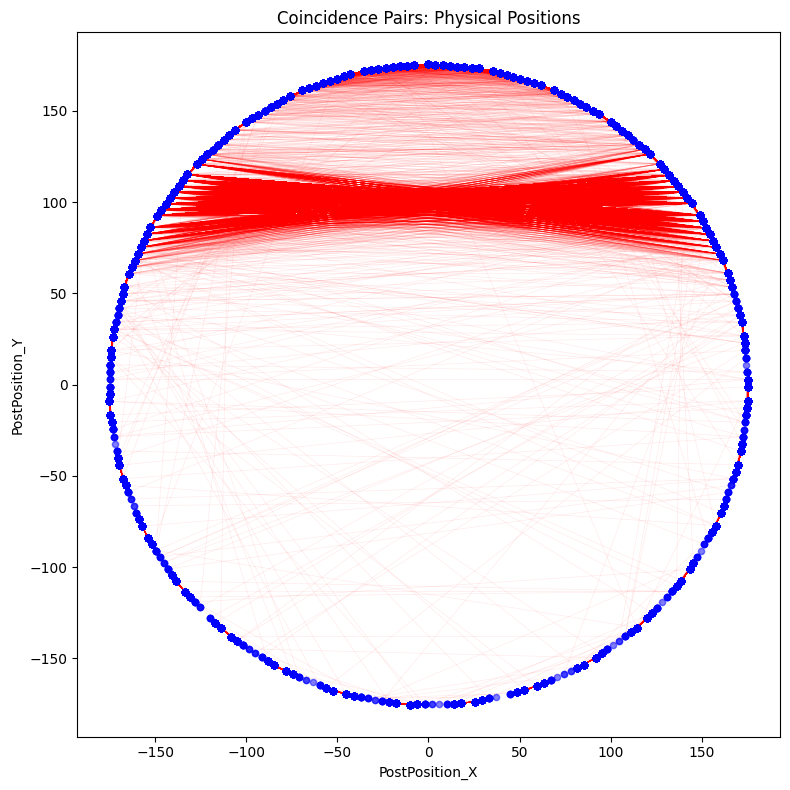

In [46]:
# Example usage:
# Assuming `coincidences_df` is your dataframe of coincidence pairs.
plot_physical_positions(coincidences_df)

In [47]:
def plot_sinogram(coincidences_df: pd.DataFrame, use_histogram: bool = False,
                  bins_theta: int = 180, bins_r: int = 180):
    """
    Plot the sinogram of coincidence pairs.
    
    For each coincidence pair, the sinogram parameters (theta, r) are calculated.
    Here, theta (in radians) is the angle of the normal to the line-of-response (LOR),
    and r is the perpendicular distance from the origin to the LOR.
    
    Parameters:
        coincidences_df (pd.DataFrame): DataFrame with coincidence pairs, containing
            'PostPosition_X_1', 'PostPosition_Y_1',
            'PostPosition_X_2', 'PostPosition_Y_2'.
        use_histogram (bool): If True, plot a 2D histogram (density image). 
                              If False, plot a scatter plot.
        bins_theta (int): Number of bins for theta (used only if use_histogram=True).
        bins_r (int): Number of bins for r (used only if use_histogram=True).
    """
    thetas = []
    rs = []
    
    # Calculate sinogram parameters for each coincidence pair.
    for _, row in coincidences_df.iterrows():
        x1 = row["PostPosition_X_1"]
        y1 = row["PostPosition_Y_1"]
        x2 = row["PostPosition_X_2"]
        y2 = row["PostPosition_Y_2"]
        
        # Midpoint of the LOR
        xm = (x1 + x2) / 2.0
        ym = (y1 + y2) / 2.0
        
        # Orientation of the LOR.
        phi = np.arctan2(y2 - y1, x2 - x1)
        
        # Sinogram angle: the normal's angle (wrapped to [0, pi)).
        theta = (phi + np.pi/2) % np.pi
        # Perpendicular distance from the origin.
        r = xm * np.cos(theta) + ym * np.sin(theta)
        
        thetas.append(theta)
        rs.append(r)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    if use_histogram:
        # Plot as a 2D histogram (density sinogram)
        h = ax.hist2d(thetas, rs, bins=[bins_theta, bins_r], cmap='gray')
        plt.colorbar(h[3], ax=ax, label='Counts')
    else:
        # Plot as a scatter plot
        ax.scatter(thetas, rs, c='black', alpha=0.5, s=10)
    
    ax.set_xlabel("Theta (radians)")
    ax.set_ylabel("r (distance)")
    ax.set_title("Sinogram of Coincidence Pairs")
    
    plt.tight_layout()
    plt.show()

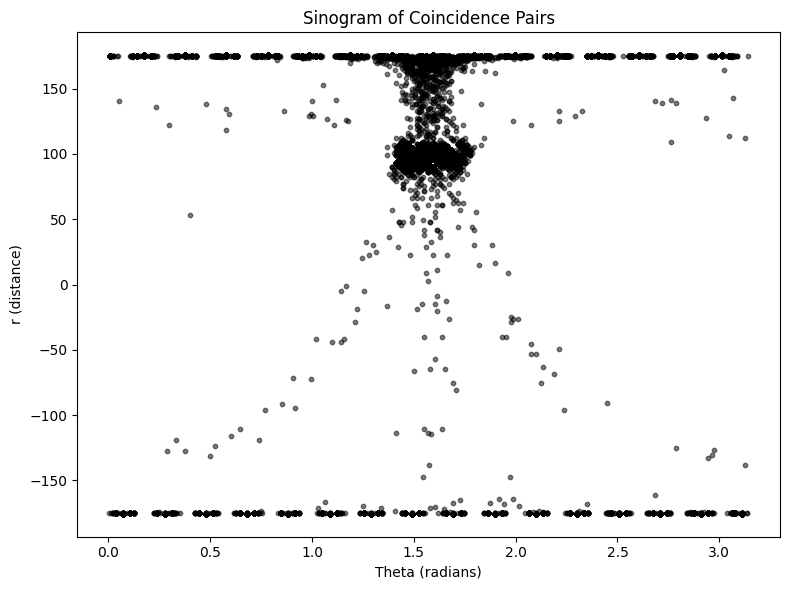

In [48]:
plot_sinogram(coincidences_df)  # For scatter plot version
#plot_sinogram(coincidences_df, use_histogram=True)  # For 2D histogram version

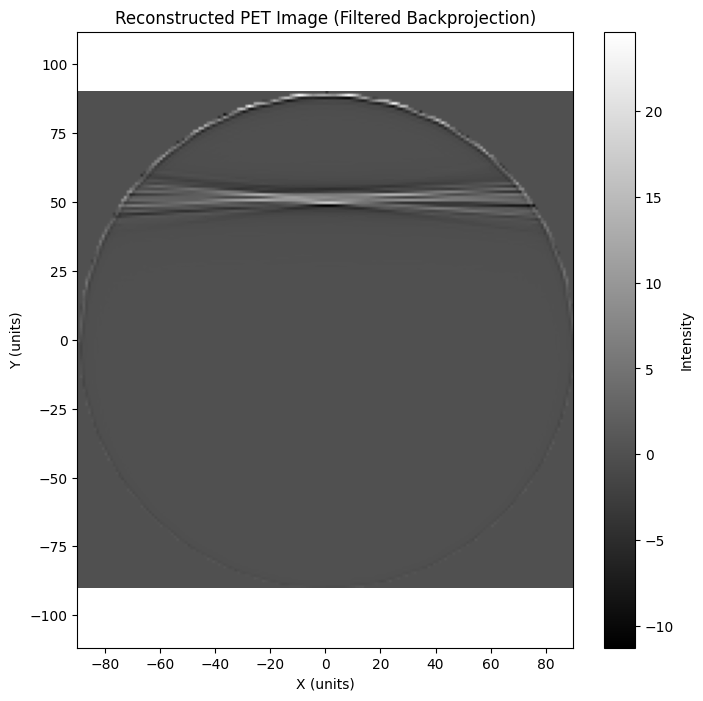

In [49]:
from skimage.transform import iradon

def compute_sinogram(coincidences_df: pd.DataFrame, bins_theta: int = 180, bins_r: int = 180):
    """
    Compute the sinogram from coincidence pairs.

    Each line-of-response (LOR) is parameterized by:
      - theta: the angle (in degrees) of the normal to the LOR (in [0,180))
      - r: the perpendicular distance from the origin to the LOR.

    Parameters:
      coincidences_df: DataFrame with coincidence pairs, containing columns:
         'PostPosition_X_1', 'PostPosition_Y_1',
         'PostPosition_X_2', 'PostPosition_Y_2'.
      bins_theta: Number of bins for theta (angles in degrees).
      bins_r: Number of bins for r (distance).

    Returns:
      sinogram: 2D numpy array (shape: [bins_r, bins_theta]).
      theta_centers: 1D array of theta bin centers (in degrees).
      r_edges: 1D array of r bin edges.
    """
    thetas = []
    rs = []

    for _, row in coincidences_df.iterrows():
        x1, y1 = row["PostPosition_X_1"], row["PostPosition_Y_1"]
        x2, y2 = row["PostPosition_X_2"], row["PostPosition_Y_2"]

        # Compute the midpoint of the LOR.
        xm = (x1 + x2) / 2.0
        ym = (y1 + y2) / 2.0

        # Orientation of the LOR (angle of the line connecting the two points)
        phi = np.arctan2(y2 - y1, x2 - x1)

        # The sinogram parameter theta is the angle of the normal to the LOR.
        theta = (phi + np.pi/2) % np.pi  # in radians

        # r is the projection of the midpoint onto the normal.
        r = xm * np.cos(theta) + ym * np.sin(theta)

        thetas.append(theta)
        rs.append(r)

    thetas = np.array(thetas)
    rs = np.array(rs)

    # Convert theta from radians to degrees.
    thetas_deg = np.degrees(thetas)

    # Define histogram bin edges.
    theta_edges = np.linspace(0, 180, bins_theta + 1)
    r_min, r_max = rs.min(), rs.max()
    r_edges = np.linspace(r_min, r_max, bins_r + 1)

    # Create 2D histogram: rows are r bins, columns are theta bins.
    sinogram, _, _ = np.histogram2d(rs, thetas_deg, bins=[r_edges, theta_edges])

    # Compute theta bin centers.
    theta_centers = (theta_edges[:-1] + theta_edges[1:]) / 2.0

    return sinogram, theta_centers, r_edges

def reconstruct_pet_image(sinogram: np.ndarray, theta_centers: np.ndarray,
                          filter_name: str = 'ramp', output_size: int = None):
    """
    Reconstruct the PET image from a sinogram using filtered backprojection.

    Parameters:
      sinogram: 2D numpy array representing the sinogram (shape: [radial bins, angles]).
      theta_centers: 1D array of projection angles (in degrees) corresponding to the sinogram columns.
      filter_name: Filter to use in backprojection (default is 'ramp').
      output_size: Optional output image size (if None, it is inferred).

    Returns:
      reconstruction: 2D numpy array representing the reconstructed image.
    """
    reconstruction = iradon(sinogram, theta=theta_centers, filter_name=filter_name,
                            circle=True, output_size=output_size)
    return reconstruction

def plot_reconstruction(reconstruction: np.ndarray):
    """
    Plot the reconstructed PET image with the origin at the centre,
    matching the coordinate system used for plotting physical coincidence positions.

    This version flips the reconstruction along the vertical axis so that
    the y-axis orientation matches that of the physical positions plot.
    """
    # Flip the image vertically to correct the y-axis orientation.
    reconstruction_flipped = np.flipud(reconstruction)
    
    nrows, ncols = reconstruction_flipped.shape
    # Set extent so that the image is centered at (0, 0)
    extent = [-ncols/2, ncols/2, -nrows/2, nrows/2]
    
    plt.figure(figsize=(8, 8))
    plt.imshow(reconstruction_flipped, cmap='gray', extent=extent, origin='lower')
    plt.title("Reconstructed PET Image (Filtered Backprojection)")
    plt.xlabel("X (units)")
    plt.ylabel("Y (units)")
    plt.colorbar(label='Intensity')
    plt.axis('equal')
    plt.show()
    
# === Example usage ===
# Assuming you have already computed a sinogram and the corresponding theta_centers,
# for example using your compute_sinogram function:

sinogram, theta_centers, r_edges = compute_sinogram(coincidences_df, bins_theta=180, bins_r=180)

# Reconstruct the PET image:
# You may specify output_size if you wish to control the dimensions.
reconstruction = reconstruct_pet_image(sinogram, theta_centers, filter_name='ramp')

# Plot the reconstructed image with the origin at the centre:
plot_reconstruction(reconstruction)
